In [138]:
import numpy as np
import pandas as pd
import datetime
import functools

In [3]:
targets = [_.strip() for _ in open('validation/targets').readlines()]

In [83]:
def read_ccsd_result(target):
    lines = open('validation/CCSD/%s/run.log' % target).readlines()
    for line in lines:
        if ' ***FINAL HARTREE-FOCK ENERGY' in line:
            E_HF = float(line.strip().split()[-2])
        if 'MP2 energy' in line:
            E_MP2 = float(line.strip().split()[-1])
        if 'Total CCSD energy' in line:
            E_CCSD = float(line.strip().split()[-1])

    times = [datetime.datetime.strptime(_[26:45], '%Y-%m-%d %H:%M:%S') for _ in lines if '************************ ' in _]
    ccsd_time = (times[-1]-times[0]).seconds/60
    mp2_time = (times[-2]-times[0]).seconds/60
    hf_time = (times[-3]-times[0]).seconds/60
    return {'target': target, 'hf_time': hf_time, 'mp2_time': mp2_time, 'ccsd_time': ccsd_time, 'HF_T': E_HF, 'MP2_T': E_MP2, 'CCSD_T': E_CCSD}

In [93]:
def read_results(fn):
    ccsd_result = []
    for target in targets:
        try:
            r = fn(target)
        except:
            continue
        ccsd_result.append(r)
    return pd.DataFrame(ccsd_result)
ccsd_df = read_results(read_ccsd_result)

In [85]:
ccsd_df.sum()

CCSD_T      -7.036894e+05
HF_T        -7.020499e+05
MP2_T       -7.036807e+05
ccsd_time    1.514472e+04
hf_time      2.470150e+03
mp2_time     7.492833e+03
target                inf
dtype: float64

In [99]:
def read_pbe_result(target):
    lines = open('validation/PBE/%s/run.log' % target).readlines()
    for line in lines:
        if 'ENERGY| Total FORCE_EVAL' in line:
            epbe = float(line.strip().split()[-1])
        if 'CP2K                                 1' in line:
            pbetime = float(line.strip().split()[-1])/60
    return {'target': target, 'PBE_T': epbe, 'pbe_time': pbetime}
            
pbe_df = read_results(read_pbe_result)
-9.772560266932857

In [127]:
pm6_df = pd.read_csv('validation/PM6.results', sep='\s+', names='target a b c PM6_T'.split())['target PM6_T'.split()]
pm6_df['PM6_T'] *= 0.0367493

(-1.8204383143239997, -4.162351033113, -6.282762491054)

In [128]:
uff_df = pd.read_csv('validation/UFF.results', sep=' ', names='target a b c UFF_T d'.split())['target UFF_T'.split()]
uff_df['UFF_T'] /= 2625.50

In [129]:
apdft_df = pd.read_csv('validation/APDFT.csv')['target APDFT0_T APDFT1_T'.split()]
combined = pd.merge(pd.merge(pd.merge(pd.merge(pbe_df, ccsd_df), uff_df), pm6_df), apdft_df)

In [140]:
@functools.lru_cache(200)
def get_atomisation_offset(method, bnpairs):
    atom = pd.read_csv('validation/atom', sep=' ')
    q = atom.query('method == @method').iloc[0]
    return (q.B + q.N)*bnpairs + 2*q.C * (10-bnpairs)
get_atomisation_offset('PBE', 2)

-109.62130618445514

In [142]:
def decorate(row):
    row['bnpairs'] = len([_ for _ in row['target'] if _ == '5'])
    for method in 'PBE CCSD HF MP2 UFF PM6 APDFT0 APDFT1'.split():
        row['%s_A' % method] = row['%s_T' % method] - get_atomisation_offset(method, row['bnpairs'])
    return row
combined = combined.apply(decorate, axis=1)

In [143]:
import matplotlib.pyplot as plt

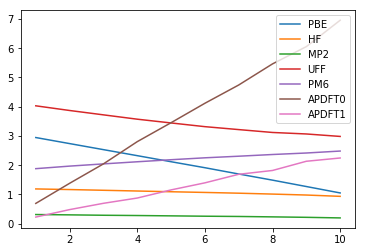

In [145]:
for method in 'PBE HF MP2 UFF PM6 APDFT0 APDFT1'.split():
    combined['deltaE'] = np.abs(combined.CCSD_A - combined['%s_A' % method])
    q = combined.groupby('bnpairs').mean().reset_index()
    plt.plot(q.bnpairs, q.deltaE, label=method)
plt.legend()